# Predicción de la variable sold_quantity

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pylab

sns.set(rc={'figure.figsize':(11.7,8.27)})
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline
plt.style.use('ggplot')
from matplotlib import pyplot



In [59]:
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV

Se lee el data set que se había preparado de la parte 2 (limpieza y análisis de estádisticas), puesto que allí se limpio la base y se crearon algunas variables:

In [3]:
dataset=pd.read_csv("./files/dataset_modelar.csv")

## Comportamiento de los datos

se quiiere ver si los datos se aproxman o que tanto se alejan de seguir una distribución normal:

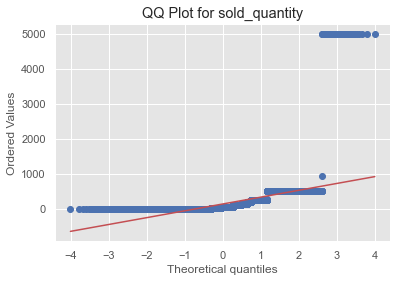

In [41]:
stats.probplot(x=dataset['object_sold_quantity'], dist = "norm", plot = plt)
plt.title("QQ Plot for sold_quantity")
plt.show()

Text(0.5, 1.0, 'sold_quantity')

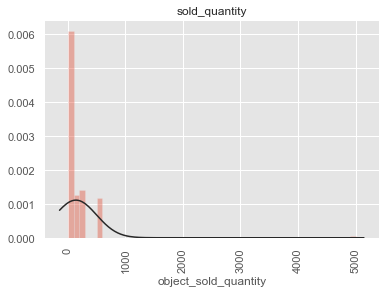

In [42]:
sns.distplot(dataset['object_sold_quantity'],fit=stats.norm, kde=False)
sns.set(color_codes=True)
plt.xticks(rotation=90)
plt.title("sold_quantity")

Podemos darnos cuenta que existe una amplia gama de cantidades vendidas de productos, y se evidencia que la distrubución de los datos no es Gaussiana, pues en el QQ plot vemos que las gráfica de los datos esta lejos de y=x. Por lo tanto un ajuste lineal no sería adecuado.

También se observa que el comportamiento de la variale respuesta parece estar dado por rangos en algunos casos, por ejemplo, no hay valores de cantidades vendidas entre 300 y 500, y luego se presenta un salto de 500 a 5000. Consultando en la página 'https://developers.mercadolibre.com.ar/es_ar/items-y-busquedas#Valores-en-campos-sold-quantity-y-available-quantity', se confirma que en los recursos públicos de Ítems y Búsquedas la información de los campos "sold_quantity" y "available_quantity" es referencial de acuerdo a ciertos rangos, por ejemplo, si el dato real de ventas esta en un rango de 501 a 5000 entonces la variable sold_quantity retorna el número 500.

In [43]:
dataset.groupby('object_sold_quantity').object_id.count().reset_index().sort_values('object_sold_quantity').head(15)

,object_sold_quantity,object_id
0,0,2949
1,1,601
2,2,452
3,3,362
4,4,294
5,5,3816
6,6,3
7,7,2
8,8,5
9,9,2


Hay muy pocos productos con números de ventas fuera de los rangos referenciales, por tanto se agrupan estos en su rango correspondiente:

In [4]:
dataset['sold_quantity']= dataset['object_sold_quantity'].apply(lambda x: 5 if (6<=x<25) 
                                                                else (25 if (26<=x<50)
                                                                     else(50 if (51<=x<100) 
                                                                         else( 100 if (101<=x<150) 
                                                                             else(150 if (151<=x<200) 
                                                                                 else(200 if (201<=x<250)
                                                                                     else(250 if (251<=x<500) 
                                                                                         else(500 if (501<=x<5000)
                                                                                             else(5000 if (5001<=x<50000)
                                                                                                 else(50000 if (50001<=x<500000) else x))))))))) )

In [5]:
dataset.groupby('sold_quantity').object_id.count().reset_index().sort_values('sold_quantity')

,sold_quantity,object_id
0,0,2949
1,1,601
2,2,452
3,3,362
4,4,294
5,5,3842
6,25,2369
7,50,2764
8,100,1623
9,150,1180


#### La nueva variable respuesta será sold_quantity y se estudiará como una varable categórica, de 14 categorías.

A continuación se transforma la variable respuesta a categórica y se eliminan del dataset las variables que no aportarán al estudio:

In [6]:
dataset['sold_quantity']=dataset['sold_quantity'].astype('category')

In [7]:
datasetmodel=dataset.drop(['object_id','object_sold_quantity','object_site_id','object_title','object_currency_id',
                      'object_stop_time','object_permalink','object_thumbnail','object_thumbnail_id',
                      'object_official_store_id','object_domain_id','object_catalog_product_id',
                      'General_category_name','sellertransactions_period','object_category_id','TAvailableVSsold'], axis=1)

Ahora veamos si hay relación entre cantidad vendida y precio como se había pensado en la parte 2 del reto:

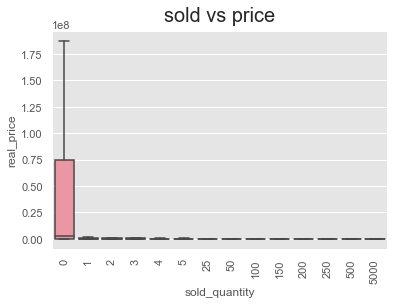

In [8]:
sns.boxplot(x='sold_quantity', y = 'real_price', data = datasetmodel,showfliers=False)

plt.title("sold vs price", fontsize=20, verticalalignment='bottom')
plt.xticks(rotation=90)
plt.rcParams['figure.figsize']=(5,5)

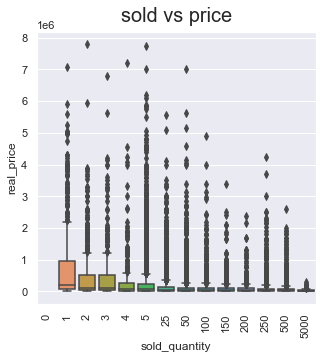

In [49]:
sns.boxplot(x='sold_quantity', y = 'real_price', data = 
            datasetmodel[~datasetmodel.sold_quantity.isin([0])])

plt.title("sold vs price", fontsize=20, verticalalignment='bottom')
plt.xticks(rotation=90)
plt.rcParams['figure.figsize']=(10,10)

##### Parece haber una relación entre las cantidades vendidas y el precio.

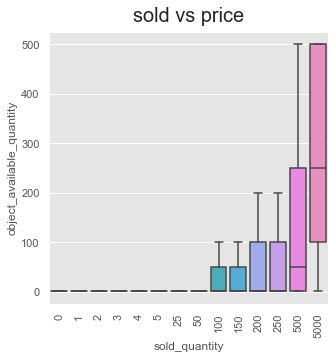

In [9]:
sns.boxplot(x='sold_quantity', y = 'object_available_quantity', data = datasetmodel,showfliers=False)

plt.title("sold vs price", fontsize=20, verticalalignment='bottom')
plt.xticks(rotation=90)
plt.rcParams['figure.figsize']=(5,5)

En las categorías que hacen referencia al mayor rango de ventas, parece haber una relación entre la cantidad vendida y la cantidad disponible.

### Se convertiran las varables categóricas en dummies y boleanas en numéricas:

In [10]:
cols = ['seller_power_status', 'seller_level', 'ship_logistic_type','ship_mode',
       'General_category_id','object_condition','object_listing_type_id','object_buying_mode']
for col in cols:
    datasetmodel = pd.concat([datasetmodel, pd.get_dummies(datasetmodel[col],drop_first=True)], axis=1)


In [11]:
bols=['object_accepts_mercadopago','object_use_thumbnail_id','free_ship','ship_storepickup']
for bol in bols:
    datasetmodel[bol] = datasetmodel[bol].astype(int)


In [12]:
  
datasetmodelfin=datasetmodel.drop(['seller_power_status', 'seller_level', 'ship_logistic_type','ship_mode',
       'General_category_id','object_condition','object_listing_type_id','object_buying_mode'], axis=1)

In [13]:
pd.options.display.max_columns = None
datasetmodelfin.head(2)

,object_available_quantity,object_accepts_mercadopago,object_original_price,object_use_thumbnail_id,free_ship,ship_storepickup,sellertransactions_canceled,sellertransactions_completed,sellertransactions_total,sellerrating_negative,sellerrating_neutral,sellerrating_positive,#_classifications,object_price,discount_value,real_price,pct_discount,thumbnail_id_binary,official_store_id_binary,catalog_product_id,is_promo,sold_quantity,no_information_sell_pw_sta,platinum,silver,2_orange,3_yellow,4_light_green,5_green,no_information_seller_level,custom,default,drop_off,fulfillment,no_information_logis_typ,not_specified,xd_drop_off,me1,me2,not_specified,MCO1039,MCO1051,MCO1071,MCO1132,MCO1144,MCO1168,MCO1182,MCO118204,MCO1246,MCO1276,MCO1367,MCO1368,MCO1384,MCO1403,MCO1430,MCO1459,MCO1499,MCO1540,MCO1574,MCO1648,MCO172890,MCO1743,MCO1747,MCO175794,MCO180800,MCO1953,MCO3025,MCO3937,MCO40433,MCO441917,MCO5726,no_information_condition,not_specified,used,free,gold,gold_premium,gold_pro,gold_special,silver,classified
0,1,1,0.0,1,1,0,1,140,141,0.00,0.04,0.96,1.0,184900.0,0.0,184900.0,0.0,0,0,0,0,5,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,150,1,0.0,1,1,0,225,8995,9220,0.02,0.01,0.97,1.0,68000.0,0.0,68000.0,0.0,0,0,0,0,4,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


## Análisis de correlación

In [14]:
X=datasetmodelfin.drop(['sold_quantity'],axis=1)

In [15]:
correlation_mat = X.corr()
corr_pairs = correlation_mat.unstack()
sorted_pairs = corr_pairs.sort_values(kind="quicksort")
strong_pairs = sorted_pairs[abs(sorted_pairs) > 0.6]
pd.set_option("max_rows", None)
strong_pairs.reset_index().sort_values(0)


,level_0,level_1,0
0,object_accepts_mercadopago,classified,-1.000000
1,classified,object_accepts_mercadopago,-1.000000
2,not_specified,me2,-0.948520
3,me2,not_specified,-0.948520
4,5_green,no_information_seller_level,-0.948512
5,no_information_seller_level,5_green,-0.948512
6,no_information_seller_level,sellerrating_positive,-0.935364
7,sellerrating_positive,no_information_seller_level,-0.935364
8,gold_premium,object_accepts_mercadopago,-0.922245
9,object_accepts_mercadopago,gold_premium,-0.922245


Se eliminan variables correlacionadas:

In [16]:
X=X.drop(['classified','not_specified', 'no_information_seller_level','object_accepts_mercadopago',
       'gold_premium','gold_pro','no_information_logis_typ','5_green','no_information_sell_pw_sta','me2','MCO1743',
                                  'is_promo','object_original_price','sellertransactions_canceled','sellertransactions_completed',
                                  'object_price','MCO1540','default','sellerrating_positive'], axis=1)

## Dividir data en test y entrenamiento y estandarizar la data

In [128]:
y = datasetmodelfin.sold_quantity

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [18]:

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Modelamiento

## 1. KNN

In [60]:
knn = KNeighborsClassifier(n_neighbors=10)
knn_train=knn.fit(X_train, y_train)

In [61]:
# Predecimos sobre nuestro set de entrenamieto
y_train_pred = knn_train.predict(X_train)

# Predecimos sobre nuestro set de test
y_test_pred = knn_train.predict(X_test)

# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', accuracy_score(y_train_pred,y_train))
print('Accuracy sobre conjunto de Test:', accuracy_score(y_test_pred,y_test))

Accuracy sobre conjunto de Train: 0.49180117858057903
Accuracy sobre conjunto de Test: 0.3883741781231321


## 2. CART

In [79]:
CART = tree.DecisionTreeClassifier()
CART_train=CART.fit(X_train, y_train)

In [80]:
# Predecimos sobre nuestro set de entrenamieto
y_train_pred = CART_train.predict(X_train)

# Predecimos sobre nuestro set de test
y_test_pred = CART_train.predict(X_test)

# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', accuracy_score(y_train_pred,y_train))
print('Accuracy sobre conjunto de Test:', accuracy_score(y_test_pred,y_test))

Accuracy sobre conjunto de Train: 0.9689341532154753
Accuracy sobre conjunto de Test: 0.3544530783024507


#### Los resultados de Accuracy sobre cada conjunto, sugieren presencia de overfitting.

In [28]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       882
           1       0.40      0.44      0.42       181
           2       0.12      0.12      0.12       131
           3       0.09      0.09      0.09       105
           4       0.07      0.07      0.07        86
           5       0.43      0.44      0.43      1113
          25       0.21      0.21      0.21       725
          50       0.24      0.23      0.24       867
         100       0.11      0.10      0.11       488
         150       0.08      0.08      0.08       347
         200       0.08      0.08      0.08       261
         250       0.23      0.21      0.22       719
         500       0.41      0.43      0.42       763
        5000       0.14      0.12      0.13        24

    accuracy                           0.36      6692
   macro avg       0.25      0.26      0.26      6692
weighted avg       0.35      0.36      0.36      6692



Observemos los cambios en las predicciones de train y test mediante la matriz de confusión:

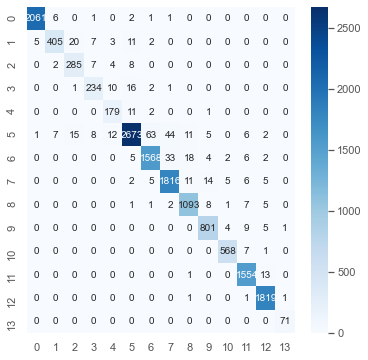

In [81]:
plt.figure(figsize = (6,6))

cf_rf = confusion_matrix(CART_train.predict(X_train),y_train)
sns.heatmap(cf_rf,cmap= "Blues", linecolor = 'black' , annot = True, fmt='')


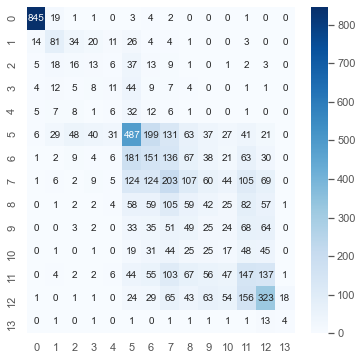

In [82]:
plt.figure(figsize = (6,6))

cf_rf = confusion_matrix(CART_train.predict(X_test),y_test)
sns.heatmap(cf_rf,cmap= "Blues", linecolor = 'black' , annot = True, fmt='')


 ## 3.LDA

In [30]:
lda = LinearDiscriminantAnalysis()
lda_train=lda.fit(X_train, y_train)

In [31]:
# Predecimos sobre nuestro set de entrenamieto
y_train_pred = lda_train.predict(X_train)

# Predecimos sobre nuestro set de test
y_test_pred = lda_train.predict(X_test)

# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', accuracy_score(y_train_pred,y_train))
print('Accuracy sobre conjunto de Test:', accuracy_score(y_test_pred,y_test))

Accuracy sobre conjunto de Train: 0.3808608762490392
Accuracy sobre conjunto de Test: 0.3750747160789002


## 4. GBC

In [32]:
GBC = GradientBoostingClassifier()
GBC_train=GBC.fit(X_train, y_train)


In [33]:
# Predecimos sobre nuestro set de entrenamieto
y_train_pred = GBC_train.predict(X_train)

# Predecimos sobre nuestro set de test
y_test_pred = GBC_train.predict(X_test)

# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', accuracy_score(y_train_pred,y_train))
print('Accuracy sobre conjunto de Test:', accuracy_score(y_test_pred,y_test))

Accuracy sobre conjunto de Train: 0.496605175506021
Accuracy sobre conjunto de Test: 0.42080095636580994


## 5. RANDOM FOREST C

In [62]:
RFC = RandomForestClassifier() 
RFC_train=RFC.fit(X_train, y_train)

In [63]:
# Predecimos sobre nuestro set de entrenamieto
y_train_pred = RFC_train.predict(X_train)

# Predecimos sobre nuestro set de test
y_test_pred = RFC_train.predict(X_test)

# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', accuracy_score(y_train_pred,y_train))
print('Accuracy sobre conjunto de Test:', accuracy_score(y_test_pred,y_test))

Accuracy sobre conjunto de Train: 0.9688060466307968
Accuracy sobre conjunto de Test: 0.3967423789599522


Para este algoritmo tambien se observa overfitting, generalmente se esto es atribuido en gran parte al hiper parámetro profundidad de los nodos. Se hará zoom en este modelo, intentando mejorar el overfittin mediante la optimización de los hiper parámetros.

## Optimización Hiper parámetros Random Forest Classifier

Se realiza una validación cruzada de busqueda aleatorea, dado que hacer busqueda exhaustiva tiene un costo computacional muy alto:

In [62]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

random_search = {'criterion': ['entropy', 'gini'],
               'max_depth': list(np.linspace(10, 1200, 10, dtype = int)) + [None],
               'max_features': ['auto', 'sqrt','log2', None],
               'min_samples_leaf': [4, 6, 8, 12],
               'min_samples_split': [5, 7, 10, 14],
               'n_estimators': list(np.linspace(151, 1200, 10, dtype = int))}

RFC = RandomForestClassifier()
model = RandomizedSearchCV(estimator = RFC, param_distributions = random_search, n_iter = 5, 
                               cv = 4, verbose= 5, random_state= 101, n_jobs = -1)
model.fit(X_train,y_train)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:  4.8min remaining:   32.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  4.9min finished


RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [10, 142, 274, 406, 538,
                                                      671, 803, 935, 1067, 1200,
                                                      None],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': [4, 6, 8, 12],
                                        'min_samples_split': [5, 7, 10, 14],
                                        'n_estimators': [151, 267, 384, 500,
                                                         617, 733, 850, 966,
                                                         1083, 1200]},
                   random_state=101, verbose=5)

In [66]:
# Predecimos sobre nuestro set de entrenamieto
y_train_pred = model.fit(X_train,y_train).predict(X_train)

# Predecimos sobre nuestro set de test
y_test_pred = model.fit(X_train,y_train).predict(X_test)


Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:  4.7min remaining:   31.5s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  4.8min finished


Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:  4.5min remaining:   29.6s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  4.5min finished


In [72]:
print('Accuracy sobre conjunto de Train:', accuracy_score(y_train_pred,y_train))
print('Accuracy sobre conjunto de Test:', accuracy_score(y_test_pred,y_test))
print("El número de estimadores seleccionado es n_estimadores={0:d}".format(model.best_params_['n_estimators']))
print("La profundidad seleccionada es n={0:d}".format(model.best_params_['max_depth']))
print(f"El método para considrar cantidad features para split es {model.best_params_['max_features']}")
print(f"El criterio elegido es {model.best_params_['criterion']}")
print(f"El # mínimo de muestras en nodo es {model.best_params_['min_samples_leaf']}")
print(f"El # mínimo de muestras para dividir un nodo es {model.best_params_['min_samples_split']}")

Accuracy sobre conjunto de Train: 0.566551370740456
Accuracy sobre conjunto de Test: 0.4251344889420203
El número de estimadores seleccionado es n_estimadores=850
La profundidad seleccionada es n=142
El método para considrar cantidad features para split es log2
El criterio elegido es gini
El # mínimo de muestras en nodo es 4
El # mínimo de muestras para dividir un nodo es 5


Con los hiper parámetros seleccionados veamos la matriz de confusión y el reporte de clasificación:

In [73]:
RFC = RandomForestClassifier(n_estimators=model.best_params_['n_estimators'],
                            max_depth=model.best_params_['max_depth'],
                            max_features=model.best_params_['max_features'],
                            criterion=model.best_params_['criterion'],
                            min_samples_leaf=model.best_params_['min_samples_leaf'],
                            min_samples_split=model.best_params_['min_samples_split']) 
RFC_train=RFC.fit(X_train, y_train)

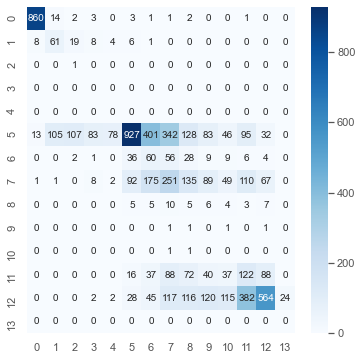

In [77]:
plt.figure(figsize = (6,6))

cf_rf = confusion_matrix(RFC_train.predict(X_test),y_test)
sns.heatmap(cf_rf,cmap= "Blues", linecolor = 'black' , annot = True, fmt='')

In [78]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       882
           1       0.57      0.34      0.42       181
           2       1.00      0.01      0.02       131
           3       0.00      0.00      0.00       105
           4       0.00      0.00      0.00        86
           5       0.38      0.83      0.52      1113
          25       0.28      0.08      0.13       725
          50       0.26      0.29      0.27       867
         100       0.11      0.01      0.02       488
         150       0.00      0.00      0.00       347
         200       0.00      0.00      0.00       261
         250       0.24      0.17      0.20       719
         500       0.37      0.74      0.50       763
        5000       0.00      0.00      0.00        24

    accuracy                           0.43      6692
   macro avg       0.30      0.25      0.22      6692
weighted avg       0.37      0.43      0.36      6692



C:\Users\AN\Anaconda3\envs\paratrabajar\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Vemos que las categorías que peor predice el modelo son las categórias sold_quantity=2, sold_quantity=3, sold_quantity=4, esto puede darse a que existe muy poca muestra en ellas, por tanto se hará un agrupamiento de estas: si la cantidad vendida esta entre 2 y 4 productos, entonces la variable sold_quantity retorna el valor 3: 

In [129]:
datasetmodelfin['sold_quantity']=datasetmodelfin['sold_quantity'].apply(lambda x: 3 if (2<=x<=4) else x)
y = datasetmodelfin.sold_quantity

C:\Users\AN\Anaconda3\envs\paratrabajar\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Ejecutamos de nuevo los anteriores procesos para llegar al modelo:

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [132]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

random_search = {'criterion': ['entropy', 'gini'],
               'max_depth': list(np.linspace(10, 1200, 10, dtype = int)) + [None],
               'max_features': ['auto', 'sqrt','log2', None],
               'min_samples_leaf': [4, 6, 8, 12],
               'min_samples_split': [5, 7, 10, 14],
               'n_estimators': list(np.linspace(151, 1200, 10, dtype = int))}

RFC = RandomForestClassifier()
model = RandomizedSearchCV(estimator = RFC, param_distributions = random_search, n_iter = 5, 
                               cv = 4, verbose= 5, random_state= 101, n_jobs = -1)
model.fit(X_train,y_train)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:  4.7min remaining:   31.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  4.7min finished


RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [10, 142, 274, 406, 538,
                                                      671, 803, 935, 1067, 1200,
                                                      None],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': [4, 6, 8, 12],
                                        'min_samples_split': [5, 7, 10, 14],
                                        'n_estimators': [151, 267, 384, 500,
                                                         617, 733, 850, 966,
                                                         1083, 1200]},
                   random_state=101, verbose=5)

In [133]:
# Predecimos sobre nuestro set de entrenamieto
y_train_pred = model.fit(X_train,y_train).predict(X_train)

# Predecimos sobre nuestro set de test
y_test_pred = model.fit(X_train,y_train).predict(X_test)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   55.8s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:  4.5min remaining:   30.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  4.5min finished


Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:  4.5min remaining:   30.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  4.5min finished


In [134]:
print('Accuracy sobre conjunto de Train:', accuracy_score(y_train_pred,y_train))
print('Accuracy sobre conjunto de Test:', accuracy_score(y_test_pred,y_test))
print("El número de estimadores seleccionado es n_estimadores={0:d}".format(model.best_params_['n_estimators']))
print("La profundidad seleccionada es n={0:d}".format(model.best_params_['max_depth']))
print(f"El método para considrar cantidad features para split es {model.best_params_['max_features']}")
print(f"El criterio elegido es {model.best_params_['criterion']}")
print(f"El # mínimo de muestras en nodo es {model.best_params_['min_samples_leaf']}")
print(f"El # mínimo de muestras para dividir un nodo es {model.best_params_['min_samples_split']}")

Accuracy sobre conjunto de Train: 0.5756469382526261
Accuracy sobre conjunto de Test: 0.43126120741183505
El número de estimadores seleccionado es n_estimadores=267
La profundidad seleccionada es n=1200
El método para considrar cantidad features para split es log2
El criterio elegido es gini
El # mínimo de muestras en nodo es 4
El # mínimo de muestras para dividir un nodo es 14


El Accuracy de ambos conjuntos mejoro un poco.

In [135]:
RFC = RandomForestClassifier(n_estimators=model.best_params_['n_estimators'],
                            max_depth=model.best_params_['max_depth'],
                            max_features=model.best_params_['max_features'],
                            criterion=model.best_params_['criterion'],
                            min_samples_leaf=model.best_params_['min_samples_leaf'],
                            min_samples_split=model.best_params_['min_samples_split']) 
RFC_train=RFC.fit(X_train, y_train)

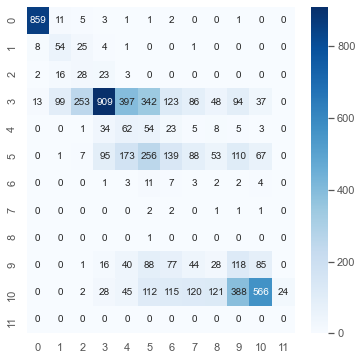

In [136]:
plt.figure(figsize = (6,6))

cf_rf = confusion_matrix(RFC_train.predict(X_test),y_test)
sns.heatmap(cf_rf,cmap= "Blues", linecolor = 'black' , annot = True, fmt='')

mejora un poco la clasificación en la categoría que contiene las cantidades vendidas entre 2 y 4 (categoría 2).

## Importancia de las variables en el modelo Random Forest

In [137]:
def plot_feature_importance(importance,names,model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')


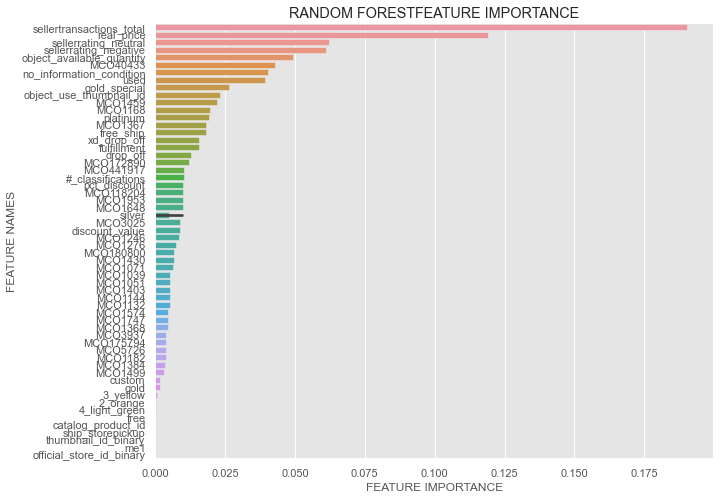

In [138]:
selected_columns = X.columns


plot_feature_importance(RFC_train.feature_importances_,selected_columns,'RANDOM FOREST')

Las varables que más aportan al modelo son:cantidad total de transacciones del vendedor, rating del vendedor = neutral, rating del vendedor = negativo, cantidad disponible, Categoría boletas para espectáculos, Sin información de la condición del producto, producto usado, entre otras. 

## Consideraciones

El modelo podría mejorarse añadiendo más variables, como por ejemplo, variables relacionads al comportamiento de ventas en las distintas épocas del año, número de veces que el producto apareció en una busqueda, número de veces que la subcategoria del producto fue visitada, número de visitas a la página del vendedor, antiguedad del vendedor en mercado libre, número de veces que han preguntado al vendedor por el producto, si la publicación del producto tiene o ha tenido campaña de publicidad (product adds).

Tambien sería interesante trabajar con la variable original de ventas, de esta manera probar modelos en los que se puedan ajustar distribuciones flexibles y así minimizar los errores de predicción causados por los valores extremos.

